# Anomaly detection
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/yggdrasil-decision-forests/blob/main/documentation/public/docs/tutorial/anomaly_detection.ipynb)


## Setup

In [ ]:
pip install ydf ucimlrepo scikit-learn umap-learn plotly -U -q

## What is anomaly detection?

**Anomaly detection** techniques are non-supervised learning algorithms for identifying rare and unusual patterns in data that deviate significantly from the norm.
For example, anomaly detection can be used for fraud detection, network intrusion detection, and fault diagnosis, without the need for defining of abnormal instances.

Anomaly detection with decision forests is a straightforward but effective technique for tabular data. The model assigns an anomaly score to each data point, ranging from 0 (normal) to 1 (abnormal). Decision forests also offer interpretability tools and properties, making it easier to understand and characterize detected anomalies.

In anomaly detection, labeled examples are used not for training but for evaluating the model. These labels ensure that the model can detect known anomalies.


We train and evaluate two anomaly detection models on the UCI Covertype dataset, which describes forest cover types and other geographic attributes of land cells. The first model is trained on pine and willow data. Given that willow is rarer than pine, the model differentiates between them without labels. This first model will then be interpreted and characterize what constitute a pine cover type.

In [1]:
# Load libraries
import ydf  # For learning the anomaly detection model
import pandas as pd  # We use Pandas to load small datasets
from sklearn import metrics  # Use sklearn to compute AUC
from ucimlrepo import fetch_ucirepo  # To download the dataset
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For plotting
import umap  # For projecting distances in 2d

# For interactive plots
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.io as pio
pio.renderers.default="colab"

# Disable Pandas warnings
pd.options.mode.chained_assignment = None

/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-17 13:06:13.648825: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 13:06:14.292005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


We download the Covertype dataset from UCI.

## Prepare dataset

In [2]:
# https://archive.ics.uci.edu/dataset/31/covertype
covertype_repo = fetch_ucirepo(id=31)
raw_dataset = pd.concat([covertype_repo.data.features, covertype_repo.data.targets], axis=1)

Select the columns of interest and clean the labels.

In [3]:
dataset = raw_dataset.copy()

# Features of interest
features = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
            "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
            "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
            "Horizontal_Distance_To_Fire_Points"]
dataset = dataset[features + ["Cover_Type"]]

# Covert type as text
dataset["Cover_Type"] = dataset["Cover_Type"].map({
    1: "Spruce/Fir",
    2: "Lodgepole Pine",
    3: "Ponderosa Pine",
    4: "Cottonwood/Willow",
    5: "Aspen",
    6: "Douglas-fir",
    7: "Krummholz"
})

dataset.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,Aspen
1,2590,56,2,212,-6,390,220,235,151,6225,Aspen
2,2804,139,9,268,65,3180,234,238,135,6121,Lodgepole Pine
3,2785,155,18,242,118,3090,238,238,122,6211,Lodgepole Pine
4,2595,45,2,153,-1,391,220,234,150,6172,Aspen


The first model is trained on the "filtered dataset" than only contain spruce/fir and cottonwood/willow examples.

In [4]:
filtered_dataset = dataset[dataset["Cover_Type"].isin(["Spruce/Fir", "Cottonwood/Willow"])]

As you can see, the spruce/fir cover is much more common than the cottonwood/willow cover:

In [5]:
filtered_dataset["Cover_Type"].value_counts()

Cover_Type
Spruce/Fir           211840
Cottonwood/Willow      2747
Name: count, dtype: int64

We train a popular anomaly detection decision forest algorithm called isolation forest.

## Anomaly detection model

In [6]:
model = ydf.IsolationForestLearner(features=features).train(filtered_dataset)

Train model on 214587 examples
Model trained in 0:00:00.074241


We can then generate "predictions" i.e. anomaly scores.

In [7]:
predictions = model.predict(filtered_dataset)
predictions[:5]

array([0.57844853, 0.609949  , 0.5433627 , 0.6099571 , 0.48067462],
      dtype=float32)

Next, we plot the model anomaly score's distribution for spruce/fir and cottonwood/willow cover. We se than both distributions are "separated", indicating the model's ability to differentiate between the two covers.

**Note:** It's important to note that since cottonwood/willow cover is less frequent, the two distributions are normalized separately. Otherwise, the cottonwood/willow distribution would appear flat.

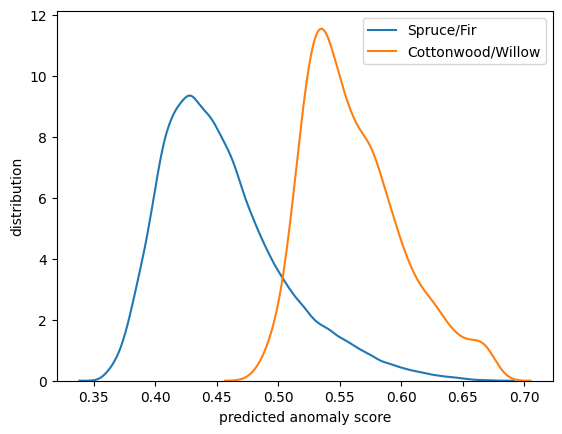

In [8]:
sns.kdeplot(predictions[filtered_dataset["Cover_Type"] == "Spruce/Fir"], label="Spruce/Fir")
sns.kdeplot(predictions[filtered_dataset["Cover_Type"] == "Cottonwood/Willow"], label="Cottonwood/Willow")
plt.xlabel("predicted anomaly score")
plt.ylabel("distribution")
plt.legend()
None

The AUC is a metric used to evaluate classification models. It can also be used to quantify the discriminative power of any signal in separating two distinct classes. In the context of anomaly detection, we can use the AUC to quantify how much our anomaly detection model is able to isolate the minority class.

The cover type information are not used to train the model and the dataset is considered static (i.e., the type of coverage does not change overtime). Therefore, we do not need to split the dataset between training and testing, and use all the data both for training the model and evaluate it with the AUC.

In [9]:
metrics.roc_auc_score(filtered_dataset["Cover_Type"] == "Cottonwood/Willow", predictions)

0.9427246186652949

This high AUC confirms that the model is well able to separate the two cover types.

We can also analyse the model to understand it: For instance, we see on the partial dependency plot of the elevation that the "normal" coverage is around 2900 and 3300 meters of altitude. Other similar conclusions can be taken by looking at other attributes.

In [10]:
model.analyze(filtered_dataset, sampling=0.001) # Use larger sampling for better results

We can also interpret individual model predictions. For example, let's select the first Cottonwood/Willow example and generate a prediction:

In [11]:
first_willow_example = filtered_dataset[filtered_dataset["Cover_Type"] == "Cottonwood/Willow"][:1]
first_willow_example

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type
1988,2000,318,7,30,4,108,201,234,172,268,Cottonwood/Willow


In [12]:
model.predict(first_willow_example)

array([0.5474113], dtype=float32)

Now, let's see how the model prediction would change with the feature values of this example:

We see than the example elevation of 2000 is uncommon and explain some of the high prediction value. On the other hand, the example "aspect" and "slope" are relatively normal.

In [13]:
model.analyze_prediction(first_willow_example)

List all the decision forest algorithms, our isolation forest model define an implicit distance between examples. This distance can be use to cluster the examples or interpretable mapping.

Let's compute the distance between each pair of examples. To make the code run fast, we only select the first 10000 examples.

In [14]:
distances = model.distance(filtered_dataset[:10000]) # Use more examples for better results
distances[:4, :4]

array([[0.       , 0.86     , 0.6766667, 0.85     ],
       [0.86     , 0.       , 0.9066667, 0.31     ],
       [0.6766667, 0.9066667, 0.       , 0.8833333],
       [0.85     , 0.31     , 0.8833333, 0.       ]], dtype=float32)

We can then use UMAP (or any other manifold learning algorithm such as T-SNE) to project the examples in a 2D plot.

Note that the cover types are well separated despite the model having never seen them.

/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/umap/umap_.py:1858: UserWarning:

using precomputed metric; inverse_transform will be unavailable



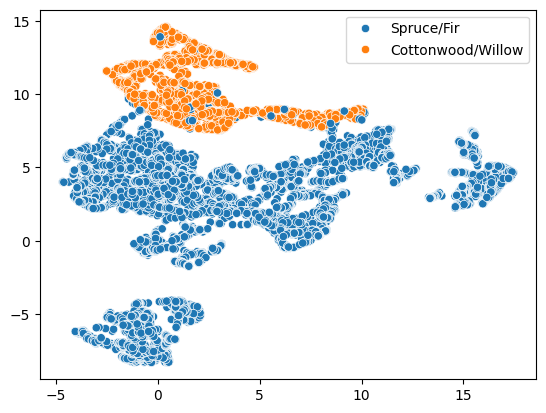

In [15]:
manifold = umap.UMAP(n_components=2, n_neighbors=10, metric="precomputed").fit_transform(distances)
sns.scatterplot(x=manifold[:, 0],
                y=manifold[:, 1],
                hue=filtered_dataset["Cover_Type"][:manifold.shape[0]])
plt.legend()